In [ ]:
# Проверка на тестовом датасете

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix

import project_module

In [319]:
reload(project_module)

<module 'project_module' from 'project_module.py'>

Загрузка данных теста

In [408]:
# Определим ОС, подготовимся к загрузке
OSTYPE = !uname
if OSTYPE == ['Linux']:
     OSTYPE = 'Linux'
else:
     OSTYPE = 'Windows'
        
source_list = None
current_dir = None
if OSTYPE == 'Linux':
    source_list = !find ./for_test/ -type f | sort
else:
    source_list = !dir "for_test/30s" /B /S
    current_dir = !echo %cd%
    current_dir = current_dir[0]

file_list = project_module.GetFilenameList(source_list, OSTYPE, current_dir)

In [409]:
# Загрузим данные
audio_data = project_module.LoadAudio(file_list, True, OSTYPE)

In [410]:
# И еще нужно загрузить метки
labels_df = pd.read_csv("models/labels.csv", index_col=0)
labels = labels_df.iloc[:, 0].to_dict()
labels_list = labels_df.index.values

In [425]:
labels_df

,id
blues,0
classical,1
country,2
disco,3
hiphop,4
jazz,5
metal,6
pop,7
reggae,8
rock,9


In [411]:
# Подготовим датасет
X_test, y_test = project_module.PrepareDataForModel(audio_data, labels)
X_test_nn, y_test_nn = project_module.PrepareDataForModel(audio_data, labels, normalize=False)

Загрузка моделей

In [412]:
# Загрузим модели
model_pcasvc = joblib.load('models/pcasvc.pkl') 
model_lda = joblib.load('models/lda.pkl')
model_pcasvc_nn = joblib.load('models/pcasvc_nn.pkl') 
model_lda_nn = joblib.load('models/lda_nn.pkl')

** Момент истины - тест! **

* Нормализованные модели

In [413]:
plt.rcParams["axes.grid"] = False

In [414]:
model_lda

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)

In [423]:
def PredictAndShow(model, X, y, name):
    y_pred = model.predict(X)
    print "Accuracy", accuracy_score(y_true=y, y_pred=y_pred)

    cnf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)
    plt.figure()
    project_module.PlotConfusionMatrix(cnf_matrix, classes=labels_list, normalize=False,  title=name)
    plt.show()
    
    return y_pred

Accuracy 0.489795918367
Confusion matrix, without normalization
[[4 0 1 0 1 0 0 0 0 4]
 [0 8 2 0 0 0 0 0 0 0]
 [1 0 4 0 1 0 1 1 0 2]
 [1 0 0 5 1 0 1 0 1 1]
 [0 0 1 2 3 1 0 1 2 0]
 [0 0 2 1 0 4 0 0 1 1]
 [1 0 0 1 0 0 7 0 0 1]
 [0 0 0 2 0 0 0 6 1 1]
 [3 0 0 0 2 0 0 0 5 0]
 [0 0 2 1 0 1 2 1 0 2]]


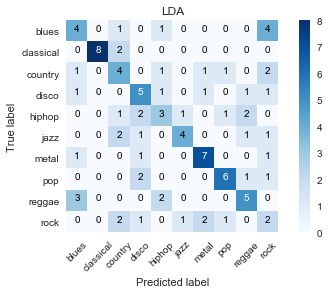

[3 7 2 8 4 0 6 9 4 0 5 9 3 0 2 3 0 7 2 2 1 3 3 7 1 9 2 8 6 9 2 2 2 7 1 8 7
 8 8 2 6 9 6 6 6 3 9 1 1 6 2 0 7 8 3 7 3 4 3 6 4 5 6 1 9 4 2 3 9 5 3 8 8 3
 6 5 0 4 1 2 9 4 9 9 0 5 4 7 6 8 0 5 1 0 9 0 7 8]
[7 7 0 4 4 0 6 5 8 6 5 9 7 2 1 9 0 9 5 9 1 5 3 4 1 3 1 8 6 0 2 2 2 7 1 4 2
 7 8 4 6 9 9 9 6 6 0 1 1 6 2 8 7 5 3 7 3 4 3 2 8 5 3 1 2 2 5 4 6 5 4 3 8 3
 6 5 8 0 1 9 7 3 0 0 8 9 4 7 6 8 0 4 1 3 2 0 7 8]


In [424]:
print PredictAndShow(model_lda, X_test, y_test, "LDA")
print y_test

Вероятностная классификация

In [417]:
#Минус - поменять порядок
y_proba = model_lda.predict_proba(X_test)
arg_sort = np.argsort(-y_proba)

count_first3 = 0
for i, sample in enumerate(arg_sort):
    position = np.where(sample == y_test[i])[0][0]
    if (position < 3):
        count_first3 += 1
        
# % треков, где нужный жанр находится среди первых 3х предложенных
print float(count_first3)/X_test.shape[0]

0.724489795918


In [418]:
# Вывод 3х предложенных жанров для 1ой песни
print "Скорее всего, это ", labels_df.iloc[arg_sort[0, 0]].name
print "но это еще может быть", labels_df.iloc[arg_sort[0, 1]].name, "или", labels_df.iloc[arg_sort[0, 2]].name
print "А на самом деле это", labels_df.iloc[y_test[0]].name

Скорее всего, это  disco
но это еще может быть blues или hiphop
А на самом деле это pop


Accuracy 0.459183673469
Confusion matrix, without normalization
[[ 2  0  4  0  1  0  0  0  1  2]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  6  2  0  0  0  1  1  0]
 [ 0  0  3  5  1  0  0  0  1  0]
 [ 0  0  4  3  2  0  0  0  1  0]
 [ 0  0  0  1  0  5  0  0  1  2]
 [ 1  0  0  1  0  0  7  0  0  1]
 [ 1  0  3  4  0  0  0  1  1  0]
 [ 0  0  1  2  1  0  0  0  6  0]
 [ 0  1  2  2  0  0  2  0  1  1]]


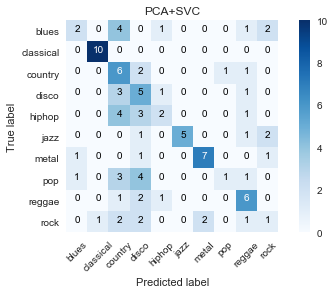

In [419]:
PredictAndShow(model_pcasvc, X_test, y_test, "PCA+SVC")

##### Мы возьмем LDA, поскольку в нем есть вероятностная классификация, что позволит несколько сгладить недостатки классификатора

* Ненормализованные модели (на всякий случай)

Accuracy 0.15306122449
Confusion matrix, without normalization
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  2  0  0  7  0  0  1  0  0]
 [ 0  0  0  0  7  0  0  3  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  2  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  5  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]]


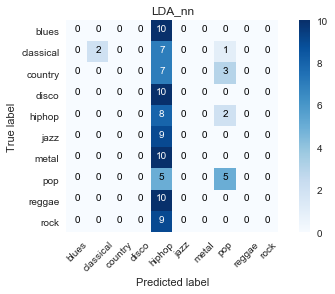

In [361]:
PredictAndShow(model_lda_nn, X_test_nn, y_test_nn, "LDA_nn")

Accuracy 0.112244897959
Confusion matrix, without normalization
[[ 1  0  0  0  9  0  0  0  0  0]
 [ 3  0  0  1  6  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 1  0  0  0  8  0  0  0  0  0]]


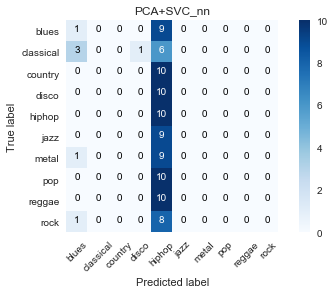

In [362]:
PredictAndShow(model_pcasvc_nn, X_test_nn, y_test_nn, "PCA+SVC_nn")

** Классификация полных песен **

In [474]:
reload(project_module)

<module 'project_module' from 'project_module.pyc'>

In [475]:
source_list_full = None

if OSTYPE == 'Linux':
    source_list_full = !find ./for_test/ -type f | sort
else:
    source_list_full = !dir "for_test/full" /B /S
    current_dir_full = !echo %cd%

file_list_full = project_module.GetFilenameList(source_list_full, OSTYPE, current_dir)

In [476]:
np.random.seed(7)

In [477]:
full_song_df = project_module.LoadAudio(file_list_full, False, OSTYPE, crop=True)

In [478]:
X_full, y_full = project_module.PrepareDataForModel(full_song_df, labels, shuffle=False)

In [479]:
y_full_proba = model_lda.predict_proba(X_full)
y_pred = model_lda.predict(X_full)
y_full_texts = list()
for i, probabilities in enumerate(y_full_proba):
    arg_sort = np.argsort(-probabilities)
    y_full_texts.append(labels_df.iloc[arg_sort[0]].name+" > "+labels_df.iloc[arg_sort[1]].name+" > "+
                        labels_df.iloc[arg_sort[2]].name)
    #print labels_df.iloc[y_pred[i]].name
    print y_full_texts[i], ", filename:", full_song_df.file_name[i]
full_song_df.genre = y_full_texts

rock > country > disco , filename: blues_HouseOfTheRisingSunTim Griffin.wav
classical > jazz > country , filename: classic_TanetsMalenkihLebedey.wav
blues > country > jazz , filename: country_BetterManLittleBigTown.wav
disco > hiphop > jazz , filename: disco_BodyTalkImagination.wav
blues > disco > hiphop , filename: hiphop_AllEyezOnMe2Pac.wav
rock > country > disco , filename: jazz_RudolphTheRedNosedReindeerEllaFitzgerald.wav
metal > disco > rock , filename: metal_AtlasRiseMetallica.wav
disco > country > rock , filename: pop_IDidSomethingBadTaylorSwift.wav
hiphop > reggae > disco , filename: raggae_DanceElephantMan.wav
metal > rock > reggae , filename: rock_AreYouDreamingDiaryofMyMisanthropy.wav


In [480]:
full_song_df

,genre,file_name,samplerate,duration,mean,std,max,min,diff_mean,diff_std
0,rock > country > disco,blues_HouseOfTheRisingSunTim Griffin.wav,22050,297,"[-1.08220154825, -7.87008147981, 2.8625429299,...","[1.58790084091, 12.4330548842, 8.46848320089, ...","[3.47568600215, 34.012276627, 30.8917274739, 3...","[-4.72582353862, -45.838430991, -36.4854122946...","[-6.78787993157, 10.7326244097, 1.30097256398,...","[13.7007547183, 18.2193883515, 10.7115089402, ..."
1,classical > jazz > country,classic_TanetsMalenkihLebedey.wav,22050,94,"[-6.80329014623, 5.8196208093, -21.7798252962,...","[1.25460913701, 5.37885858332, 7.82125908636, ...","[-3.6451523635, 17.8111058911, 0.875938762424,...","[-9.58442442397, -12.4031252542, -40.704080833...","[12.6229109555, -27.5994461055, 21.8113852913,...","[5.67041721986, 7.98452755221, 8.97860018852, ..."
2,blues > country > jazz,country_BetterManLittleBigTown.wav,22050,259,"[-2.3169200911, 11.4090939386, -4.7188699338, ...","[1.59891677603, 10.3167681263, 10.4024907012, ...","[1.89782787251, 33.7910560918, 31.9322898062, ...","[-6.1209842825, -28.6300608624, -40.9136499262...","[13.7260140297, -16.1279638724, 8.24906112873,...","[11.3891895737, 14.134192424, 14.804268733, 13..."
3,disco > hiphop > jazz,disco_BodyTalkImagination.wav,22050,368,"[-3.43467950121, -8.61310433631, -6.9382062908...","[2.34171337313, 10.7621917038, 11.3477921122, ...","[0.770909058518, 23.2267176031, 29.0416654545,...","[-13.478176947, -34.1651248505, -39.7319867259...","[-5.1784248351, 1.67489804542, 7.43868953804, ...","[11.9369072438, 18.7860414019, 15.8312104974, ..."
4,blues > disco > hiphop,hiphop_AllEyezOnMe2Pac.wav,22050,246,"[0.258186196759, -12.2424843138, -4.3435828353...","[1.37572391792, 10.7334762413, 11.7410127677, ...","[3.21133884334, 18.335002916, 34.7707081512, 4...","[-4.98600819209, -47.4624991788, -37.480240257...","[-12.5006705106, 7.89890147844, 10.507827919, ...","[11.3067988384, 17.943815599, 15.9504843495, 1..."
5,rock > country > disco,jazz_RudolphTheRedNosedReindeerEllaFitzgerald.wav,22050,93,"[-0.665291118706, -6.48880279133, -8.741785070...","[1.10721363848, 7.94082324788, 9.28829139301, ...","[2.82192502717, 11.4707544327, 27.4092417969, ...","[-5.02686435234, -38.6443343393, -35.321960799...","[-5.82351167262, -2.25298227884, 4.92121423562...","[8.54383473607, 14.0546051838, 11.0665729402, ..."
6,metal > disco > rock,metal_AtlasRiseMetallica.wav,22050,388,"[1.38943636743, -19.5335800078, -6.36420485032...","[0.925844138557, 5.68799824052, 7.74055276772,...","[3.21442946442, 10.0675553747, 21.8719780717, ...","[-3.52459137994, -34.7698115289, -34.752770690...","[-20.9230163752, 13.1693751575, 12.2162646469,...","[6.45554898221, 10.8571358635, 10.395224705, 8..."
7,disco > country > rock,pop_IDidSomethingBadTaylorSwift.wav,22050,215,"[-1.12346416614, -7.66050812738, -1.6307317545...","[2.01193371923, 10.3902605507, 10.6915668315, ...","[3.99241451135, 26.6604066646, 34.7756504926, ...","[-8.33928152673, -53.2663354893, -43.655909476...","[-6.53704396124, 6.02977637279, -10.0524189716...","[11.9725439236, 16.2834022339, 14.2570818559, ..."
8,hiphop > reggae > disco,raggae_DanceElephantMan.wav,22050,211,"[0.294434855761, -18.074707549, -9.31654317455...","[1.21613131336, 7.25393119185, 9.26716614239, ...","[3.04696283932, 9.64545352127, 24.2620099981, ...","[-6.04353218669, -44.1454023038, -45.327472199...","[-18.3691424048, 8.75816437445, 6.55286365541,...","[7.800942497, 11.4630533944, 12.9971101918, 10..."
9,metal > rock > reggae,rock_AreYouDreamingDiaryofMyMisanthropy.wav,22050,175,"[0.194491425766, -9.44683559067, -22.525314648...","[1.44892522706, 6.84404409347, 8.83586267607, ...","[2.82148835301, 9.42155828122, 25.181060562, 2...","[-7.15039856494, -40.9141142044, -60.662308279...","[-9.64132701644, -13.0784790575, 25.1204382063...","[7.40421157064, 13.4371871301, 14.3817504899, ..."
